### Stock Forecasting & Direction Prediction Snippet

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load processed stock data
all_stocks = pd.read_csv("../data/processed/all_stocks_clean.csv")
all_stocks["Date"] = pd.to_datetime(all_stocks["Date"])

# Focus on one ticker first (e.g., AAPL)
df = all_stocks[all_stocks["Ticker"]=="AAPL"].copy()
df = df.sort_values("Date")

#### feature engineering

In [16]:
df["Return"] = df["Close"].pct_change()
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)  # 1 if next day up, else 0

# Simple Moving Averages
df["SMA10"] = df["Close"].rolling(10).mean()
df["SMA50"] = df["Close"].rolling(50).mean()

# Exponential Moving Average
df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()

# Volatility (rolling standard deviation)
df["Volatility"] = df["Return"].rolling(10).std()

# Momentum indicator (difference in moving averages)
df["Momentum"] = df["SMA10"] - df["SMA50"]

# RSI (Relative Strength Index, 14-day)
window = 14
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# MACD (trend signal)
df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]

# Lagged Returns
df["Lag1"] = df["Return"].shift(1)
df["Lag2"] = df["Return"].shift(2)

# Drop missing values
df = df.dropna()



#### Test/train Split

In [17]:
# ----------------------------
# Train/Test Split
# ----------------------------
features = ["Lag1", "Lag2", "SMA10", "SMA50", "EMA20",
            "Volatility", "Momentum", "RSI", "MACD"]

X = df[features]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


#### Random Forest Classifier

In [18]:
# ----------------------------
# Random Forest (Tuned)
# ----------------------------
rf = RandomForestClassifier(
    n_estimators=500,          # more trees for stability
    max_depth=None,            # let trees grow deep
    class_weight="balanced",   # handle imbalance between up/down
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#### Evaluation

In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5578512396694215
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       113
           1       0.58      0.65      0.61       129

    accuracy                           0.56       242
   macro avg       0.55      0.55      0.55       242
weighted avg       0.55      0.56      0.55       242



#### Visualize Predictions

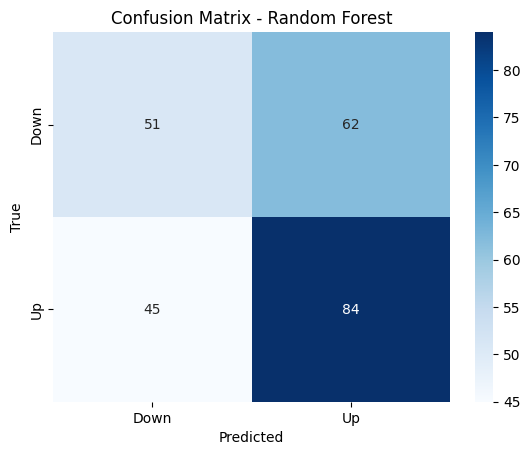

In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

#### Feature Importance

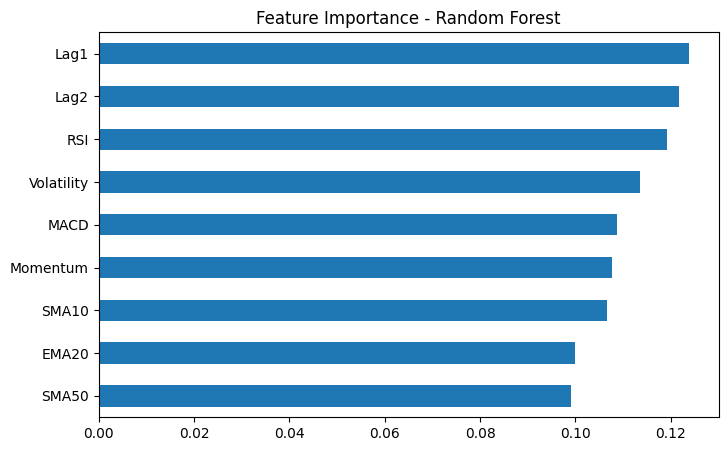

In [21]:
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance - Random Forest")
plt.show()